## MSA on PyTorch Network trained on MNIST 

This is an example of how we can perform **"Multiperturbation Shapley value Analysis"** on a PyTorch neural network. We train a three layer [input, hidden, output] network with 32 neurons in the hidden layer. We use MSA to analyse the contribution of each neuron in the hidden layer in accurately predicting the classes. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut, plottings as pl
# ---------
from functools import partial
from typing import Union, Optional, List

CM = 1 / 2.54
SEED = 42
RNG = np.random.default_rng(SEED)
FIGPATH = "figures/mnist/"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
# Device configuration
device = torch.device('cpu')
device

device(type='cpu')

### Loading Data

In [5]:
mnist_transforms = T.Lambda(lambda x: torch.flatten(x, 1)/255)

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = mnist_transforms, 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = mnist_transforms
)

train_data = TensorDataset(mnist_transforms(train_data.data.to(device)), train_data.targets.to(device))
test_data = TensorDataset(mnist_transforms(test_data.data.to(device)), test_data.targets.to(device))

In [6]:
trainloader = DataLoader(train_data, 
                        batch_size=64, 
                        shuffle=True)
    
testloader = DataLoader(test_data, 
                        batch_size=1024)

### Model Definition

In [7]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 32)
        self.layer2 = nn.Sequential(nn.LeakyReLU(),
                                    nn.Linear(32, 10))

    def forward(self, x: torch.Tensor, lesion_idx: Optional[Union[int, List[int]]] = None) -> torch.Tensor:
        """forward function to calculate the scores for each class

        Args:
            x (torch.Tensor): data of shape [batch_size, 28*28]
            lesion_idx (Optional[Union[int,List[int]]], optional): the neuron that we want to lesion in the hidden layer1. Defaults to None i.e. no lesioning performed.

        Returns:
            torch.Tensor: scores for each class
        """
        out = self.layer1(x)

        if lesion_idx:
            out[:, lesion_idx] = 0  # set the value to 0 for the lesioned neuron

        return self.layer2(out)


model = MNISTNet().to(device)

initial_weight = (model.layer1.weight.detach().numpy().copy(), model.layer2[1].weight.detach().numpy().copy())

### Training the Model

In [8]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [9]:
@torch.no_grad()
def evaluate_model(model, lesion_idx: Optional[Union[int, List[int]]] = None, num_batches: int = -1, score_fn=accuracy_score):
    """return the accuracy of the model on test dataset

    Args:
        lesion_idx (Optional[Union[int,List[int]]], optional): the neuron that we want to lesion in the hidden layer1. Defaults to None i.e. no lesioning performed.
        num_batches (int, optional): the number of batches we want to test our model. Defaults to -1 i.e. all data

    Returns:
        float: test accuracy
    """

    targets = []
    preds = []
    for i, data in enumerate(testloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images, lesion_idx)
        # the class with the highest score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)
        targets.append(labels)

        if i == (num_batches-1):
            break

    return score_fn(torch.concat(preds).cpu(), torch.concat(targets).cpu())

def accuracy_each_class(targets, preds):
    matrix = confusion_matrix(targets, preds)
    acc = []
    for i, val in enumerate(matrix.diagonal()/(matrix.sum(axis=1)+ 1e-6)):
        acc.append(val)

    return np.array(acc)

def objective_fun(lesion_idx, model, num_batches, score_fn):
    return evaluate_model(model, lesion_idx, num_batches, score_fn)

In [10]:
def train(model, epochs, optimizer, l1_regularization=False):
    loss_func = nn.CrossEntropyLoss()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            if l1_regularization:
                l1_lambda = 0.0001
                l1_norm = sum(p.abs().sum()
                  for p in model.parameters())
                loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 400 == 399:    # print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
                running_loss = 0.0

    print('Finished Training')

train(model, 3, optimizer)
evaluate_model(model)

/home/sdixit/miniconda3/envs/msapy/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1,   400] loss: 0.360
[1,   800] loss: 0.218
[2,   400] loss: 0.166
[2,   800] loss: 0.153
[3,   400] loss: 0.134
[3,   800] loss: 0.134
Finished Training


0.9596

In [11]:
print(f"the accuracy of the model on the first batch without leasoning is: {evaluate_model(model, num_batches=1)}")

the accuracy of the model on the first batch without leasoning is: 0.9599609375


In [12]:
ground_truth_elements = list(range(32)) #Indices for the neurons in the hidden layer
print(f'total number of possible lesions: {2**len(ground_truth_elements)}')

total number of possible lesions: 4294967296


Now we perform the MSA to calculate the contributions for each neuron

Note: You might want to change the device to cpu while running MSA if you have to load the data into the GPU at every iteration. This could become a bottleneck. If your data is already on the gpu than it's not a problem

<AxesSubplot:>

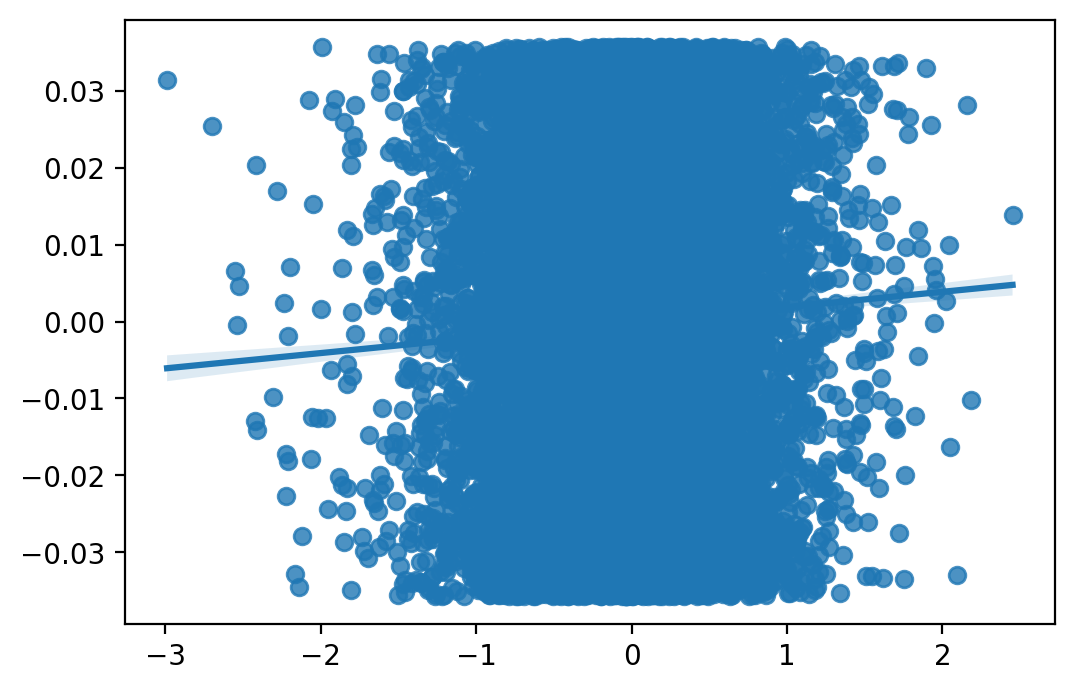

In [13]:
plt.figure(dpi = 200)
sns.regplot(x=model.layer1.weight.view(-1).detach().numpy(), y=initial_weight[0].flatten())

<AxesSubplot:>

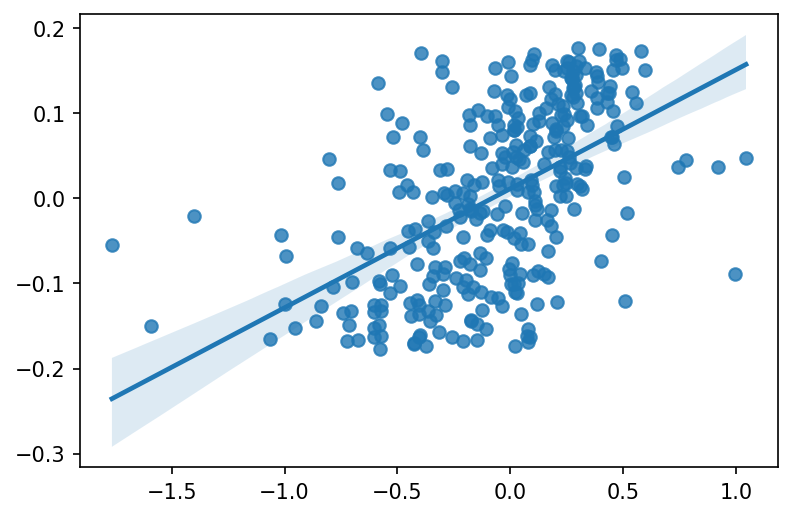

In [14]:
plt.figure(dpi = 150)
sns.regplot(x=model.layer2[1].weight.view(-1).detach().numpy(), y=initial_weight[1].flatten())

In [15]:
np.corrcoef(model.layer2[1].weight.view(-1).detach().numpy(), initial_weight[1].flatten())

array([[1.        , 0.53682877],
       [0.53682877, 1.        ]])

In [16]:
shapley_table = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1000, # might want to increase it for better results
    objective_function=partial(objective_fun, model=model, score_fn=accuracy_score, num_batches=1), #only the first batch to save time. But the batch size is 1024 i.e ~100 images per class
    rng=RNG)

<AxesSubplot:title={'center':'Shapley values for neurons in hidden layer'}, xlabel='Shapley values', ylabel='Elements'>

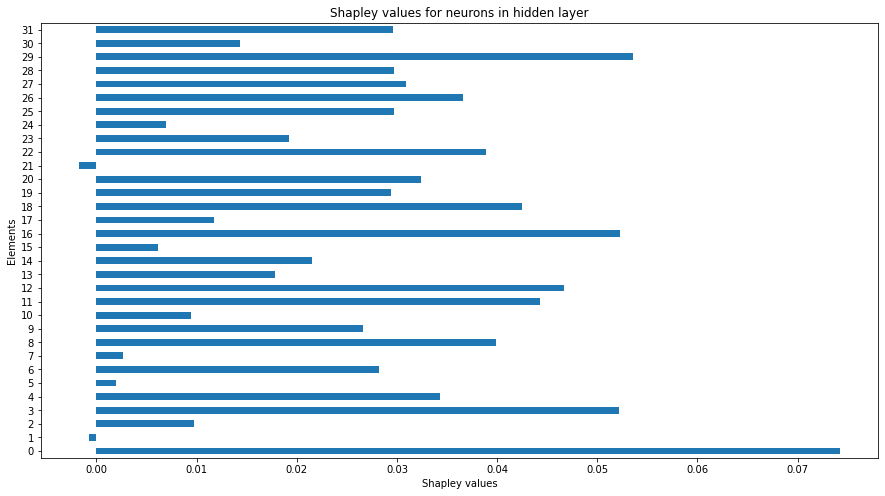

In [17]:
shapley_table.mean().plot(kind='barh', figsize=(15,8), xlabel="Shapley values", ylabel="Elements",
                                 title="Shapley values for neurons in hidden layer")

<AxesSubplot:>

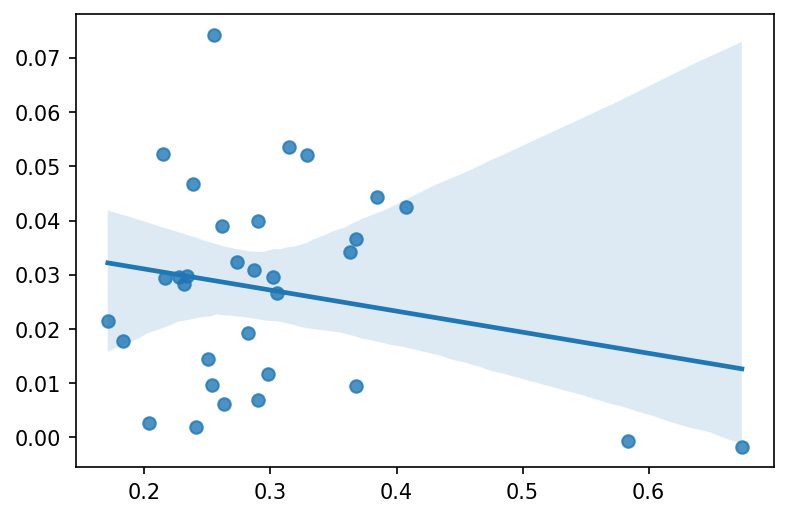

In [18]:
plt.figure(dpi = 150)
sns.regplot(x=model.layer2[1].weight.abs().mean(0).detach().numpy(), y=shapley_table.mean())

-0.09374485267526993

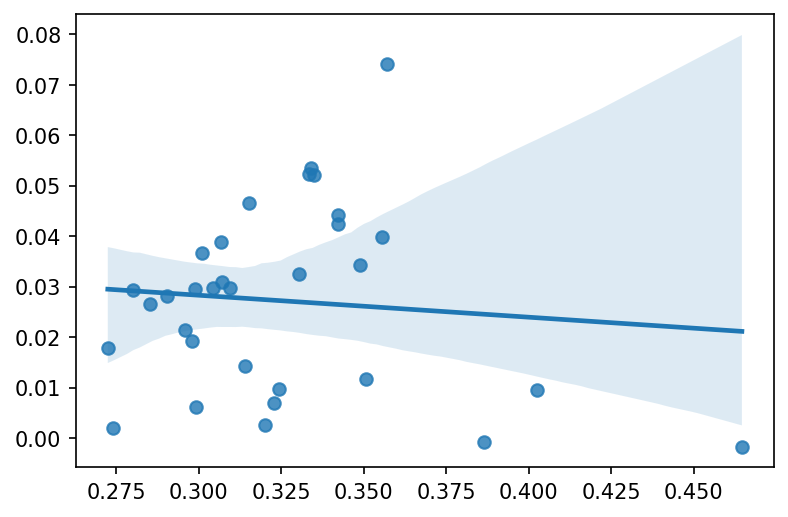

In [19]:
plt.figure(dpi = 150)
sns.regplot(x=model.layer1.weight.abs().mean(1).detach().numpy(), y=shapley_table.mean())
np.corrcoef(model.layer1.weight.abs().mean(1).detach().numpy(), shapley_table.mean())[0, 1]

In [20]:
model_regularized_l2 = MNISTNet().to(device)
optimizer = optim.Adam(model_regularized_l2.parameters(), lr = 0.01, weight_decay=1e-4)
train(model_regularized_l2, 3, optimizer)
evaluate_model(model_regularized_l2)

[1,   400] loss: 0.343
[1,   800] loss: 0.214
[2,   400] loss: 0.169
[2,   800] loss: 0.175
[3,   400] loss: 0.165
[3,   800] loss: 0.147
Finished Training


0.9537

In [21]:
shapley_table_regularized = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1000, # might want to increase it for better results
    objective_function=partial(objective_fun, model=model_regularized_l2, score_fn=accuracy_score, num_batches=1), #only the first batch to save time. But the batch size is 1024 i.e ~100 images per class
    rng=RNG)

<AxesSubplot:title={'center':'Shapley values for neurons in hidden layer'}, xlabel='Shapley values', ylabel='Elements'>

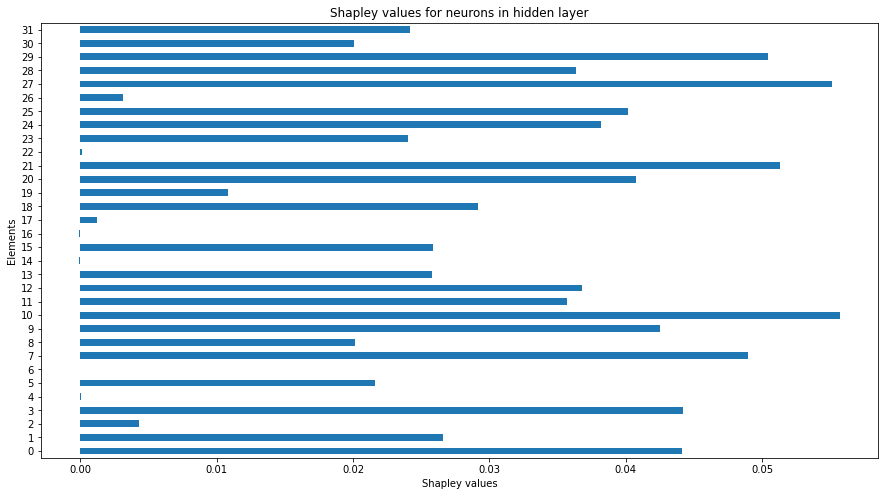

In [22]:
shapley_table_regularized.mean().plot(kind='barh', figsize=(15,8), xlabel="Shapley values", ylabel="Elements",
                                 title="Shapley values for neurons in hidden layer")

0.6724218997183044

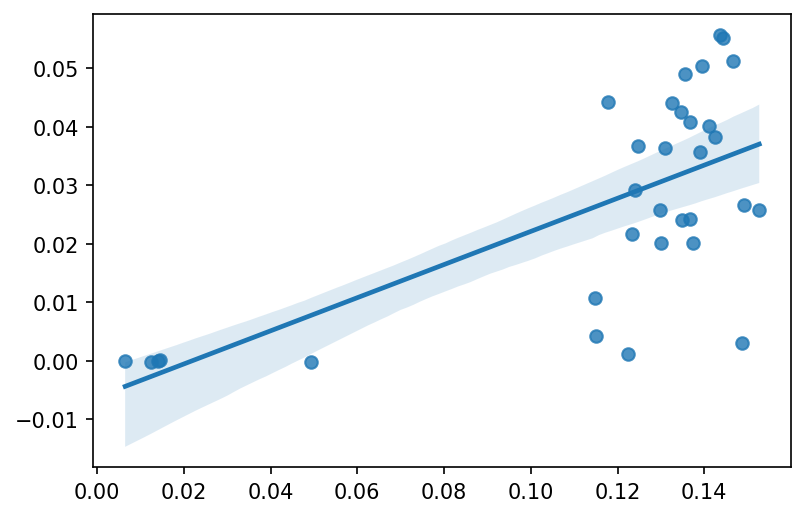

In [23]:
plt.figure(dpi = 150)
sns.regplot(x=model_regularized_l2.layer1.weight.abs().mean(1).detach().numpy(), y=shapley_table_regularized.mean())
np.corrcoef(model_regularized_l2.layer1.weight.abs().mean(1).detach().numpy(), shapley_table_regularized.mean())[1, 0]

0.4913907089282669

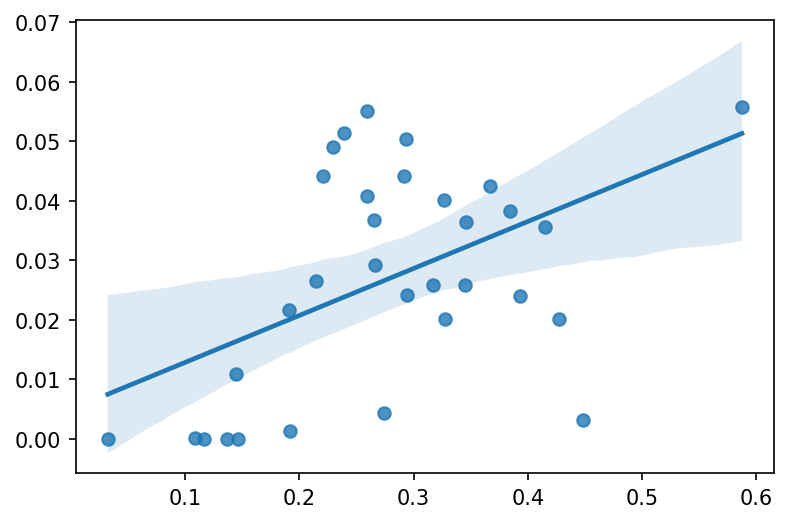

In [24]:
plt.figure(dpi = 150)
sns.regplot(x=model_regularized_l2.layer2[1].weight.abs().mean(0).detach().numpy(), y=shapley_table_regularized.mean())
np.corrcoef(model_regularized_l2.layer2[1].weight.abs().mean(0).detach().numpy(), shapley_table_regularized.mean())[1, 0]

In [25]:
model_regularized_l1 = MNISTNet().to(device)
optimizer = optim.Adam(model_regularized_l1.parameters(), lr = 0.01)
train(model_regularized_l1, 3, optimizer, True)
evaluate_model(model_regularized_l1)

[1,   400] loss: 0.487
[1,   800] loss: 0.373
[2,   400] loss: 0.334
[2,   800] loss: 0.349
[3,   400] loss: 0.334
[3,   800] loss: 0.326
Finished Training


0.9506

In [26]:
shapley_table_l1_regularized = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1000, # might want to increase it for better results
    objective_function=partial(objective_fun, model=model_regularized_l1, score_fn=accuracy_score, num_batches=1), #only the first batch to save time. But the batch size is 1024 i.e ~100 images per class
    rng=RNG)

<AxesSubplot:title={'center':'Shapley values for neurons in hidden layer'}, xlabel='Shapley values', ylabel='Elements'>

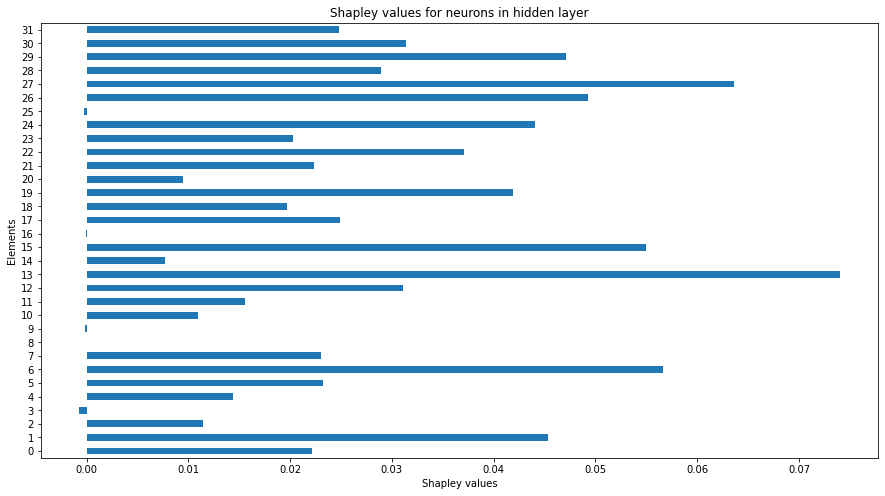

In [27]:
shapley_table_l1_regularized.mean().plot(kind='barh', figsize=(15,8), xlabel="Shapley values", ylabel="Elements",
                                 title="Shapley values for neurons in hidden layer")

0.7367140353962904

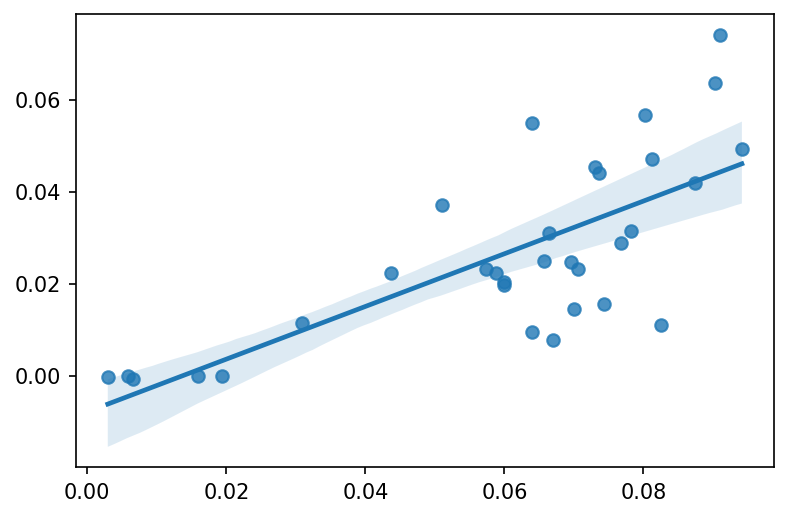

In [28]:
plt.figure(dpi = 150)
sns.regplot(x=model_regularized_l1.layer1.weight.abs().mean(1).detach().numpy(), y=shapley_table_l1_regularized.mean())
np.corrcoef(model_regularized_l1.layer1.weight.abs().mean(1).detach().numpy(), shapley_table_l1_regularized.mean())[1, 0]

0.716214063952305

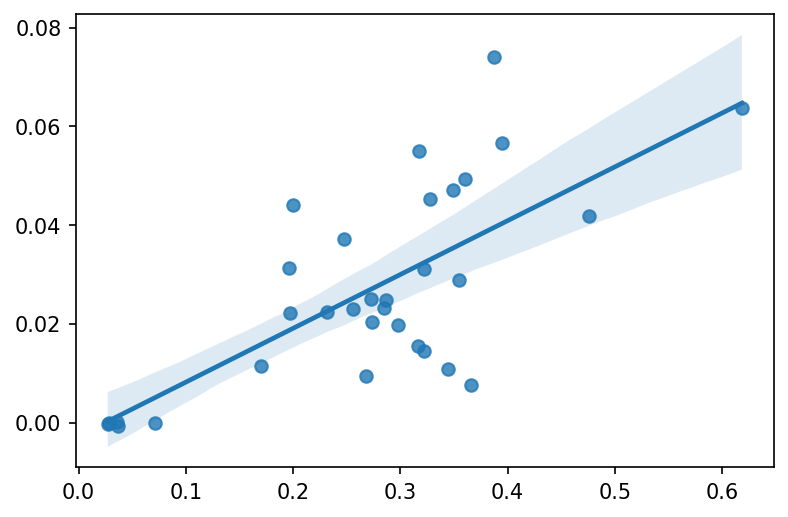

In [29]:
plt.figure(dpi = 150)
sns.regplot(x=model_regularized_l1.layer2[1].weight.abs().mean(0).detach().numpy(), y=shapley_table_l1_regularized.mean())
np.corrcoef(model_regularized_l1.layer2[1].weight.abs().mean(0).detach().numpy(), shapley_table_l1_regularized.mean())[1, 0]

In [36]:
def perform_shapley(model, optimizer, l1_regularization=False):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    init_out_degree_weight = model.layer2[1].weight.detach().clone()
    init_in_degree_weight = model.layer1.weight.detach().clone()
    train(model, 3, optimizer, l1_regularization)
    print(evaluate_model(model))
    shapley_table = msa.interface(
        elements=ground_truth_elements,
        n_permutations=1000,  # might want to increase it for better results
        objective_function=partial(
            objective_fun, model=model, score_fn=accuracy_score, num_batches=1
        ),  # only the first batch to save time. But the batch size is 1024 i.e ~100 images per class
    )
    return (
        shapley_table.mean().values,
        model.layer1.weight.abs().mean(1).detach().numpy(),
        model.layer2[1].weight.abs().mean(0).detach().numpy(),
        (init_in_degree_weight - model.layer1.weight).abs().mean(1).detach().numpy(),
        (init_out_degree_weight - model.layer2[1].weight).abs().mean(0).detach().numpy(),
    )

In [37]:
shapley_tables, in_degree_weights, out_degree_weights, in_degree_weights_diff, out_degree_weights_diff = [], [], [], [], []

for i in range(5):
    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    out = perform_shapley(model, optimizer)

    shapley_tables.append(out[0])
    in_degree_weights.append(out[1])
    out_degree_weights.append(out[2])
    in_degree_weights_diff.append(out[3])
    out_degree_weights_diff.append(out[4])


[1,   400] loss: 0.344
[1,   800] loss: 0.204
[2,   400] loss: 0.158
[2,   800] loss: 0.160
[3,   400] loss: 0.134
[3,   800] loss: 0.140
Finished Training


[1,   400] loss: 0.337
[1,   800] loss: 0.207
[2,   400] loss: 0.147
[2,   800] loss: 0.156
[3,   400] loss: 0.122
[3,   800] loss: 0.138
Finished Training


[1,   400] loss: 0.343
[1,   800] loss: 0.202
[2,   400] loss: 0.153
[2,   800] loss: 0.151
[3,   400] loss: 0.121
[3,   800] loss: 0.134
Finished Training


[1,   400] loss: 0.347
[1,   800] loss: 0.200
[2,   400] loss: 0.156
[2,   800] loss: 0.158
[3,   400] loss: 0.134
[3,   800] loss: 0.140
Finished Training


[1,   400] loss: 0.349
[1,   800] loss: 0.215
[2,   400] loss: 0.163
[2,   800] loss: 0.157
[3,   400] loss: 0.135
[3,   800] loss: 0.137
Finished Training


<AxesSubplot:>

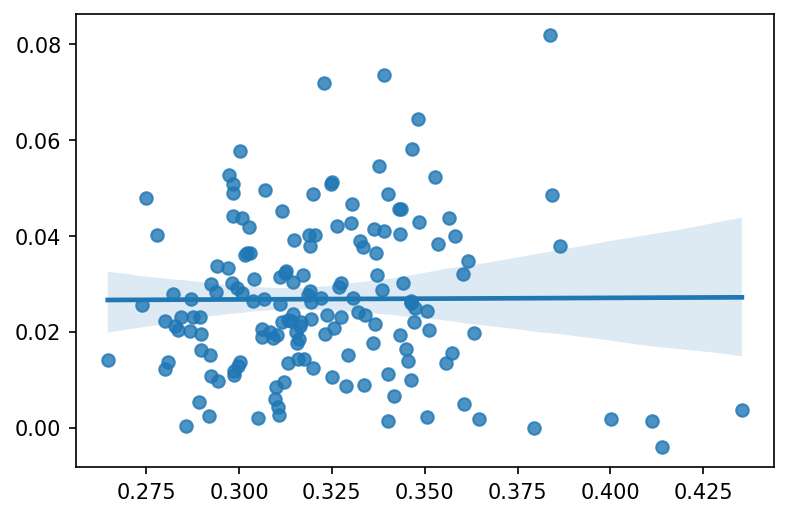

In [38]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(in_degree_weights), y=np.concatenate(shapley_tables))

In [41]:
shapley_tables_l1_regularized, in_degree_weights_l1_regularized, out_degree_weights_l1_regularized, in_degree_weights_diff_l1_regularized, out_degree_weights_diff_l1_regularized = [], [], [], [], []

for i in range(5):
    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    out = perform_shapley(model, optimizer, True)

    shapley_tables_l1_regularized.append(out[0])
    in_degree_weights_l1_regularized.append(out[1])
    out_degree_weights_l1_regularized.append(out[2])
    in_degree_weights_diff_l1_regularized.append(out[3])
    out_degree_weights_diff_l1_regularized.append(out[4])

[1,   400] loss: 0.483
[1,   800] loss: 0.377
[2,   400] loss: 0.337
[2,   800] loss: 0.336
[3,   400] loss: 0.315
[3,   800] loss: 0.335
Finished Training


[1,   400] loss: 0.483
[1,   800] loss: 0.383
[2,   400] loss: 0.344
[2,   800] loss: 0.348
[3,   400] loss: 0.321
[3,   800] loss: 0.331


[1,   400] loss: 0.496
[1,   800] loss: 0.370
[2,   400] loss: 0.346
[2,   800] loss: 0.328
[3,   400] loss: 0.330
[3,   800] loss: 0.337
Finished Training


[1,   400] loss: 0.483
[1,   800] loss: 0.376
[2,   400] loss: 0.335
[2,   800] loss: 0.344
[3,   400] loss: 0.331
[3,   800] loss: 0.327
Finished Training


[1,   400] loss: 0.489
[1,   800] loss: 0.357
[2,   400] loss: 0.339
[2,   800] loss: 0.336
[3,   400] loss: 0.332
[3,   800] loss: 0.326
Finished Training


<AxesSubplot:>

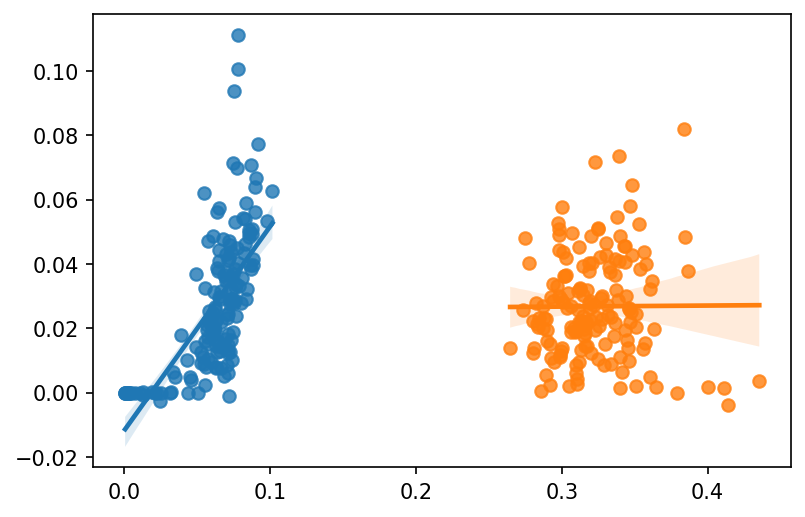

In [42]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(in_degree_weights_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized))
sns.regplot(x=np.concatenate(in_degree_weights), y=np.concatenate(shapley_tables))

In [43]:
shapley_tables_l2_regularized, in_degree_weights_l2_regularized, out_degree_weights_l2_regularized, in_degree_weights_diff_l2_regularized, out_degree_weights_diff_l2_regularized = [], [], [], [], []

for i in range(5):
    model = MNISTNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-4)
    out = perform_shapley(model, optimizer, False)

    shapley_tables_l2_regularized.append(out[0])
    in_degree_weights_l2_regularized.append(out[1])
    out_degree_weights_l2_regularized.append(out[2])
    in_degree_weights_diff_l2_regularized.append(out[3])
    out_degree_weights_diff_l2_regularized.append(out[4])

[1,   400] loss: 0.357
[1,   800] loss: 0.211
[2,   400] loss: 0.158
[2,   800] loss: 0.158
[3,   400] loss: 0.132
[3,   800] loss: 0.137
Finished Training


[1,   400] loss: 0.345
[1,   800] loss: 0.212
[2,   400] loss: 0.160
[2,   800] loss: 0.155
[3,   400] loss: 0.132
[3,   800] loss: 0.128
Finished Training


[1,   400] loss: 0.365
[1,   800] loss: 0.215
[2,   400] loss: 0.165
[2,   800] loss: 0.167
[3,   400] loss: 0.132
[3,   800] loss: 0.138
Finished Training


[1,   400] loss: 0.358
[1,   800] loss: 0.223
[2,   400] loss: 0.171
[2,   800] loss: 0.168
[3,   400] loss: 0.133
[3,   800] loss: 0.141


[1,   400] loss: 0.367
[1,   800] loss: 0.219
[2,   400] loss: 0.161
[2,   800] loss: 0.157
[3,   400] loss: 0.133
[3,   800] loss: 0.139
Finished Training


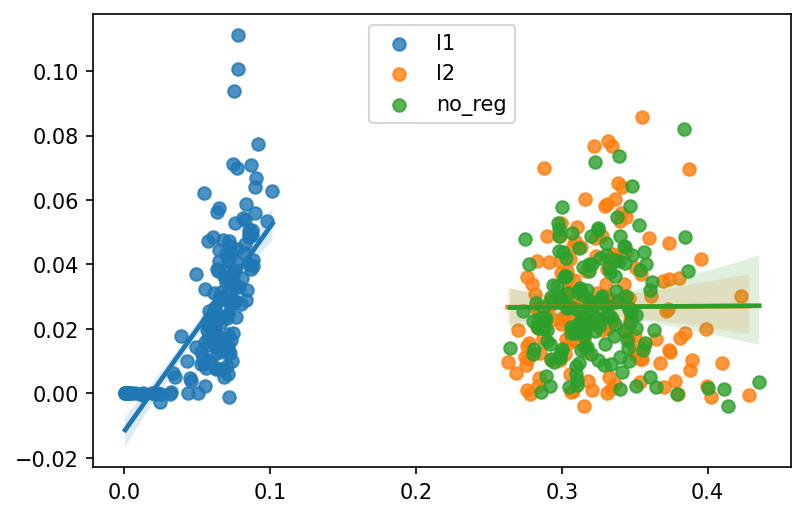

In [44]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(in_degree_weights_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized), label="l1")
sns.regplot(x=np.concatenate(in_degree_weights_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized), label="l2")
sns.regplot(x=np.concatenate(in_degree_weights), y=np.concatenate(shapley_tables), label="no_reg")
plt.legend()

In [45]:
print(np.corrcoef(x=np.concatenate(in_degree_weights_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized))[0, 1])
print(np.corrcoef(x=np.concatenate(in_degree_weights_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized))[0, 1])
print(np.corrcoef(x=np.concatenate(in_degree_weights), y=np.concatenate(shapley_tables))[0, 1])

0.6782522748867399
0.0038773858422964766
0.005818171695801501


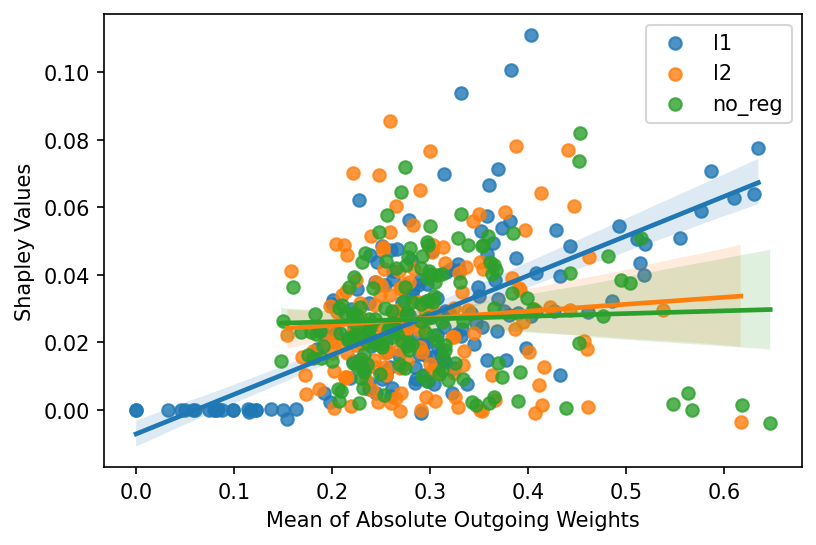

In [53]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(out_degree_weights_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized), label="l1")
sns.regplot(x=np.concatenate(out_degree_weights_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized), label="l2")
sns.regplot(x=np.concatenate(out_degree_weights), y=np.concatenate(shapley_tables), label="no_reg")
plt.xlabel("Mean of Absolute Outgoing Weights")
plt.ylabel("Shapley Values")
plt.legend()

In [47]:
print(np.corrcoef(x=np.concatenate(out_degree_weights_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized))[0, 1])
print(np.corrcoef(x=np.concatenate(out_degree_weights_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized))[0, 1])
print(np.corrcoef(x=np.concatenate(out_degree_weights), y=np.concatenate(shapley_tables))[0, 1])

0.6571660044445425
0.08702260044526143
0.0458034963958407


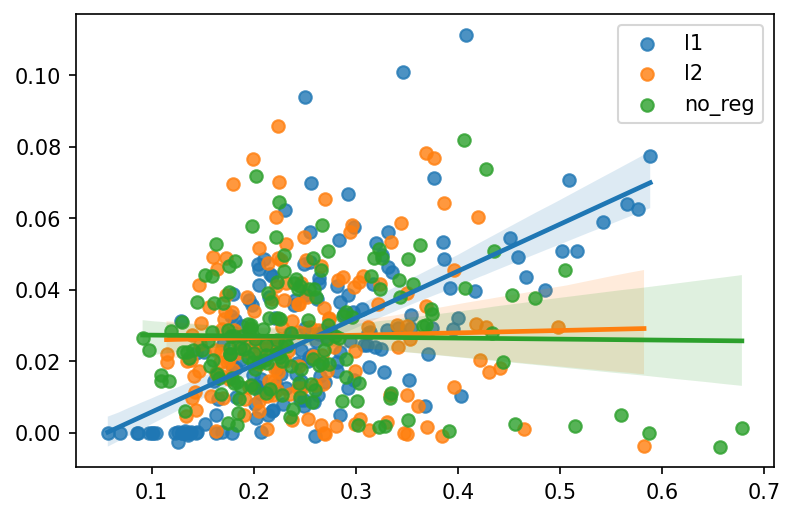

In [48]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(out_degree_weights_diff_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized), label="l1")
sns.regplot(x=np.concatenate(out_degree_weights_diff_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized), label="l2")
sns.regplot(x=np.concatenate(out_degree_weights_diff), y=np.concatenate(shapley_tables), label="no_reg")
plt.legend()

In [52]:
print(np.corrcoef(np.concatenate(out_degree_weights_diff_l1_regularized), np.concatenate(shapley_tables_l1_regularized))[0, 1])
print(np.corrcoef(np.concatenate(out_degree_weights_diff_l2_regularized), np.concatenate(shapley_tables_l2_regularized))[0, 1])
print(np.corrcoef(np.concatenate(out_degree_weights_diff), np.concatenate(shapley_tables))[0, 1])

0.6256280674673327
0.0300610659638877
-0.018096417178577927


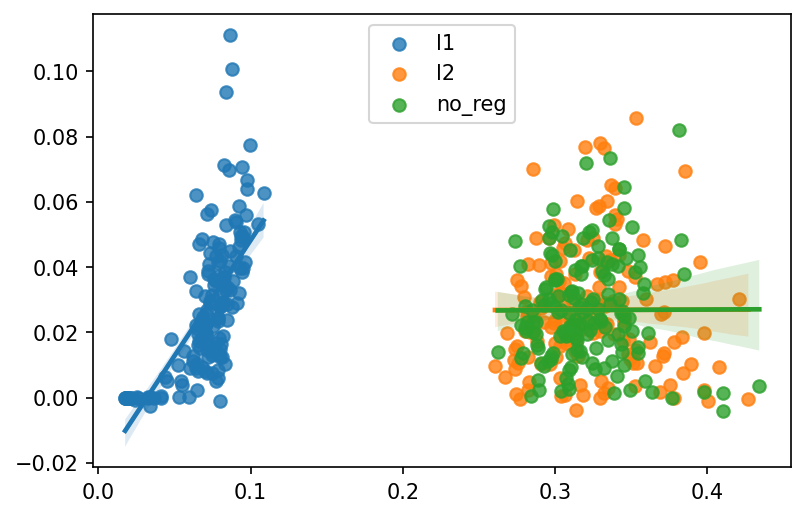

In [49]:
plt.figure(dpi = 150)
sns.regplot(x=np.concatenate(in_degree_weights_diff_l1_regularized), y=np.concatenate(shapley_tables_l1_regularized), label="l1")
sns.regplot(x=np.concatenate(in_degree_weights_diff_l2_regularized), y=np.concatenate(shapley_tables_l2_regularized), label="l2")
sns.regplot(x=np.concatenate(in_degree_weights_diff), y=np.concatenate(shapley_tables), label="no_reg")
plt.legend()